In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from lungmask import LMInferer
from sklearn.metrics import f1_score
rootpath = "//Zkh/appdata/RTDicom/DAMEproject/LUNGSABR_data_2022/NIFTI_v0/0843413/"

In [2]:
def dice_coefficient(image1, image2):
    intersection = np.sum(image1 & image2)
    union = np.sum(image1 | image2)
    
    dice = (2.0 * intersection) / (union + intersection)
    return dice

In [33]:
def cropLungMask(ct_image,rt_image=None,cropBool=True):
    kdiv =64
    inferer = LMInferer()
    lungmask = inferer.apply(ct_image)
    ct_array = sitk.GetArrayFromImage(ct_image)
    mask_array = lungmask
    
    if not cropBool:
        return mask_array
    
    mask_bb = np.where(mask_array>0)
    min_indices = [np.min(bb) for bb in mask_bb]
    max_indices = [np.max(bb) for bb in mask_bb]
    
    padding = kdiv - ((max_indices[0] - min_indices[0] + 1) % kdiv)
    padding = max(0, padding)  # Ensure padding is non-negative
    padding=0
    min_indices = [max(0, idx - padding) for idx in min_indices]
    max_indices = [min(dim_size - 1, idx + padding) for idx, dim_size in zip(max_indices, ct_array.shape)]

    cropped_ct_array = ct_array[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
    cropped_ct_image = sitk.GetImageFromArray(cropped_ct_array)
    cropped_ct_image.SetOrigin(ct_image.GetOrigin())
    cropped_ct_image.SetSpacing(ct_image.GetSpacing())

    cropped_mask_array = mask_array[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
    cropped_mask_image = sitk.GetImageFromArray(cropped_mask_array)
    cropped_mask_image.SetOrigin(cropped_mask_image.GetOrigin())
    cropped_mask_image.SetSpacing(cropped_mask_image.GetSpacing())

    
    if rt_image is not None:
        rt_array = sitk.GetArrayFromImage(rt_image)
        cropped_rt_array = rt_array[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, min_indices[2]:max_indices[2]+1]
        cropped_AidditionalImage = sitk.GetImageFromArray(cropped_rt_array)
        cropped_AidditionalImage.SetOrigin(cropped_AidditionalImage.GetOrigin())
        cropped_AidditionalImage.SetSpacing(cropped_AidditionalImage.GetSpacing())

        return cropped_ct_image,cropped_mask_image,cropped_AidditionalImage
            
    else:
        return cropped_ct_image,cropped_mask_image
    
    

In [4]:
image_50 = sitk.ReadImage(rootpath+"0843413_T=50%,PR=44% - 54%,AR()=70 - 78_ct.nii.gz")
image_60 = sitk.ReadImage(rootpath+"0843413_T=60%,PR=55% - 64%,AR()=67 - 79_ct.nii.gz")
image_00 = sitk.ReadImage(rootpath+"0843413_T=0%,PR=96% - 5%,AR()=25 - 39_ct.nii")
gtv_image =  sitk.ReadImage(rootpath+"0843413_rtstruct_GTV.nii.gz")

In [5]:
#Prepare 50% BP
image50_crop,image50_lungmask,gtv_crop = cropLungMask(image_50,gtv_image)
print(sitk.GetArrayFromImage(image50_lungmask).shape,sitk.GetArrayFromImage(image50_crop).shape,sitk.GetArrayFromImage(gtv_crop).shape)
image50_cropClamp = sitk.Clamp(image50_crop, lowerBound=-1024, upperBound=600)
array50_cropClamp = sitk.GetArrayFromImage(image50_cropClamp)
array50_lungmask= sitk.GetArrayFromImage(image50_lungmask)
arraygtv_50 = sitk.GetArrayFromImage(gtv_crop)

lungmask 2023-12-11 11:22:28 No GPU found, using CPU instead


10it [02:09, 12.94s/it]                        
100%|██████████| 16/16 [00:00<00:00, 29.20it/s]


(90, 148, 228) (90, 148, 228) (90, 148, 228)


In [6]:
#Prepare 00 BP
image00_crop,image00_lungmask = cropLungMask(image_00)
image00_cropClamp = sitk.Clamp(image00_crop, lowerBound=-1024, upperBound=600)
array00_cropClamp = sitk.GetArrayFromImage(image00_cropClamp)
array00_lungmask= sitk.GetArrayFromImage(image00_lungmask)

lungmask 2023-12-11 11:24:45 No GPU found, using CPU instead


10it [02:25, 14.51s/it]                        
100%|██████████| 18/18 [00:00<00:00, 25.24it/s]


In [25]:
image_50.GetDirection()

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

In [ ]:
sitk.WriteImage(image00_lungmask, rootpath+"0843413_CT=0%_LungMask.nii.gz)
sitk.WriteImage(image50_lungmask, rootpath+"0843413_CT=50%_LungMask.nii.gz)

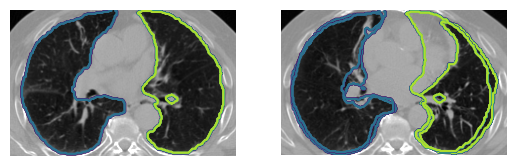

In [8]:
#DISPLAY
count=0
for i in range(arraygtv_50.shape[-3]):
    if np.sum(arraygtv_50[i,:,:])>0:
        plt.subplot(121),plt.imshow(array50_cropClamp[i,:,:],cmap='gray'),plt.axis("off")
        #plt.contour(arraygtv_50[i,:,:])
        plt.contour(array50_lungmask[i,:,:])
        plt.subplot(122),plt.imshow(array00_cropClamp[i,:,:],cmap='gray'),plt.axis("off")
        #plt.contour(arraygtv_50[i,:,:])
        plt.contour(array00_lungmask[i,:,:])   
        plt.contour(array50_lungmask[i,:,:])
        plt.show()
        count+=1
        if count>0:
            break
        

In [9]:
def BSplineFun(fixed_image,moving_image):
    control_point = 3
    order = 1

    registration_method = sitk.ImageRegistrationMethod()
    #Metrics
    registration_method.SetMetricAsCorrelation()
    #registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.3)
    #Optimizer
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=0.1, minStep=1e-4, numberOfIterations=200)
    bspline_transform = sitk.BSplineTransformInitializer(fixed_image, transformDomainMeshSize=[control_point]*fixed_image.GetDimension(), order=order)
    registration_method.SetInitialTransform(bspline_transform, inPlace=False)
    registration_method.SetShrinkFactorsPerLevel([4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel([2, 1, 0])

    # Perform the registration
    final_transform = registration_method.Execute(fixed_image, moving_image)
    evaluation_metric = registration_method.GetMetricValue()
    initial_metric_value = registration_method.MetricEvaluate(fixed_image, moving_image)
    print(f"Initial metric value: {initial_metric_value}")
    print(f"Final metric value: {evaluation_metric}")

    return final_transform



In [39]:
#Registering Lung Masks
fixed_image = image00_lungmask
moving_image = image50_lungmask
fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)

final_transform_LM = BSplineFun(fixed_image,moving_image)

resampled_image_LM = sitk.Resample(image50_cropClamp, image00_cropClamp, final_transform_LM, sitk.sitkLinear , 0.0, image50_cropClamp.GetPixelID())

#DICE 
lungMask_resampled = cropLungMask(resampled_image_LM,rt_image=None,cropBool=False)
fixed_array = sitk.GetArrayFromImage(image00_lungmask)
binary_fixed_array = (fixed_array > 0.5).astype(int)
binary_moved_array = (lungMask_resampled> 0.5).astype(int)
print("Dice between registrated Lungs:",dice_coefficient(binary_fixed_array, binary_moved_array))


Initial metric value: -0.4579371348379384
Final metric value: -0.9191163477009252
lungmask 2023-12-11 14:00:00 No GPU found, using CPU instead


101%|██████████| 5/4.95 [00:58<00:00, 11.69s/it]
100%|██████████| 7/7 [00:00<00:00, 57.85it/s]


Dice between registrated Lungs: 0.7175040978955196


In [40]:
#Registering CTs
fixed_image = image00_cropClamp
moving_image = image50_cropClamp
fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)

final_transform_CT = BSplineFun(fixed_image,moving_image)

resampled_image_CT = sitk.Resample(image50_cropClamp, image00_cropClamp, final_transform_CT, sitk.sitkLinear , 0.0, image50_cropClamp.GetPixelID())

#DICE 
lungMask_resampled = cropLungMask(resampled_image_CT,rt_image=None,cropBool=False)
fixed_array = sitk.GetArrayFromImage(image00_lungmask)
binary_fixed_array = (fixed_array > 0.5).astype(int)
binary_moved_array = (lungMask_resampled> 0.5).astype(int)
print("Dice between registrated Lungs:",dice_coefficient(binary_fixed_array, binary_moved_array))

Initial metric value: -0.43181558043669394
Final metric value: -0.7305168720236928
lungmask 2023-12-11 14:15:54 No GPU found, using CPU instead


101%|██████████| 5/4.95 [00:58<00:00, 11.78s/it]
100%|██████████| 15/15 [00:00<00:00, 72.82it/s]


Dice between registrated Lungs: 0.7675632816794394


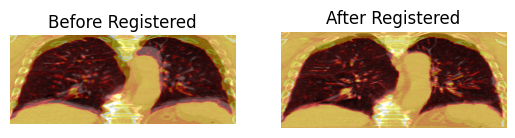

In [38]:
resampled_array = sitk.GetArrayFromImage(resampled_image_LM)
count=0
for i in range(arraygtv_50.shape[-2]):
    if np.sum(arraygtv_50[:,i,:])>0:
        plt.subplot(121),plt.imshow(array00_cropClamp[:,i,:],cmap='gray'),plt.axis("off")
        plt.imshow(array50_cropClamp[:,i,:],cmap='hot',alpha=0.5,),plt.axis("off")
        #plt.contour(arraygtv_50[i,:,:])        
        plt.gca().invert_yaxis(),plt.title("Before Registered")
        plt.subplot(122),plt.imshow(array00_cropClamp[:,i,:],cmap='gray'),plt.axis("off")
        plt.imshow(resampled_array[:,i,:],cmap='hot',alpha=0.5,),plt.axis("off")
        plt.gca().invert_yaxis(),plt.title("After Registered")
        plt.show()
        count+=1
        if count>=0:
            break
        

Dice between registrated Lungs: 0.7607387543870643


In [11]:
slice_index = 45 
deformation_field = sitk.Image(fixed_image.GetSize(), sitk.sitkVectorFloat64)
deformation_field.SetSpacing(fixed_image.GetSpacing())
deformation_field.SetOrigin(fixed_image.GetOrigin())
deformation_field.SetDirection(fixed_image.GetDirection())

for x in range(fixed_image.GetWidth()):
    for y in range(fixed_image.GetHeight()):
            index = (x, y, slice_index)
            fixed_point = fixed_image.TransformIndexToPhysicalPoint(index)
            moving_point = final_transform.TransformPoint(fixed_point)
            deformation_vector = np.array(moving_point) - np.array(fixed_point)
            deformation_field.SetPixel(index, deformation_vector)

deformation_field_slice = deformation_field[:,:,slice_index]
deformation_array = sitk.GetArrayViewFromImage(deformation_field_slice)
displacement_magnitude = np.sqrt(deformation_array[:, :, 0]**2 + deformation_array[:, :, 1]**2)
moving_contour = sitk.GetArrayFromImage(moving_image)

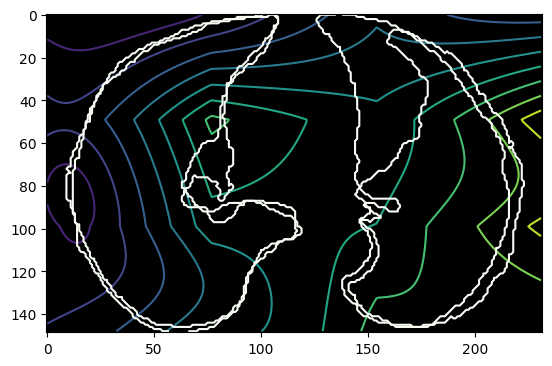

In [30]:
xx = np.linspace(0,x,x+1)
yy = np.linspace(0,y,y+1)

plt.imshow(np.zeros([y+1,x+1]),cmap="gray")
plt.contour(xx, yy, displacement_magnitude, levels=10, cmap='viridis')
plt.contour(resampled_array[slice_index,:,:], levels=0,cmap="Greens")
plt.contour(moving_contour[slice_index,:,:], levels=0,cmap="Greens")
plt.show()

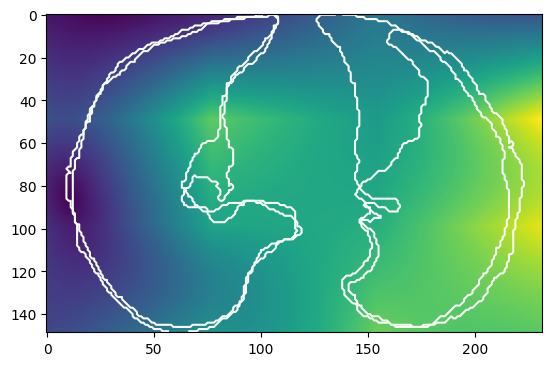

In [31]:
plt.imshow(displacement_magnitude)
plt.contour(resampled_array[slice_index,:,:], levels=0,cmap="Greens")
plt.contour(moving_contour[slice_index,:,:], levels=0,cmap="Greens")
plt.show()

In [46]:
#Resample 
gtv_crop_int = sitk.Cast(gtv_crop,sitk.sitkInt16)
resampled_gtv = sitk.Resample(gtv_crop_int, fixed_image, final_transform, sitk.sitkNearestNeighbor, 0, gtv_crop_int.GetPixelID())
#TO ARRAY
arrayGtv_resampled = sitk.GetArrayFromImage(resampled_gtv)


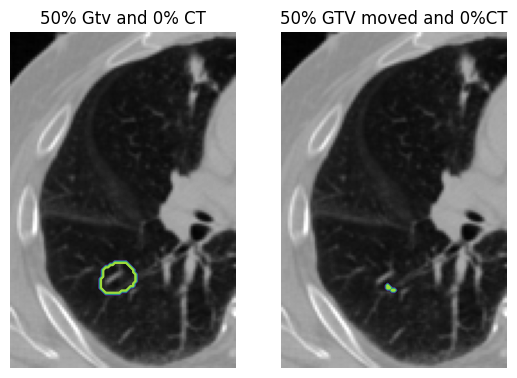

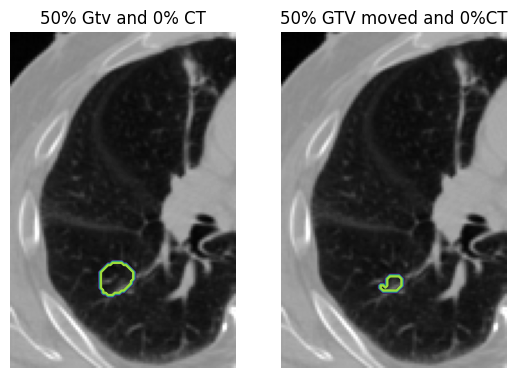

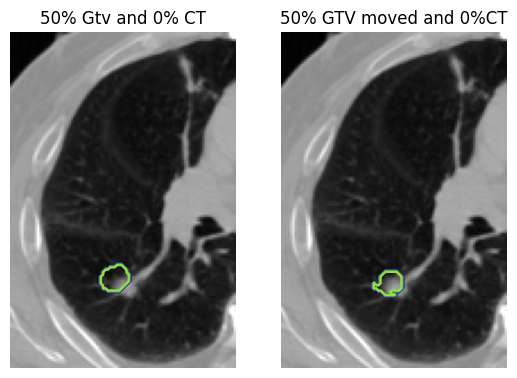

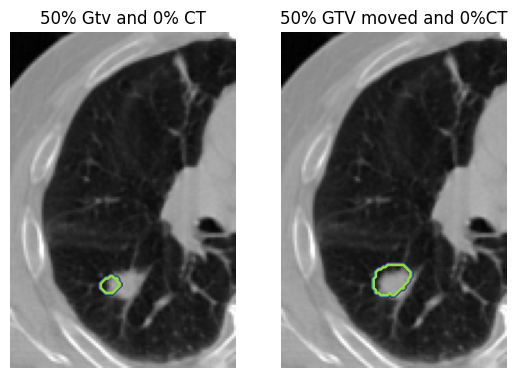

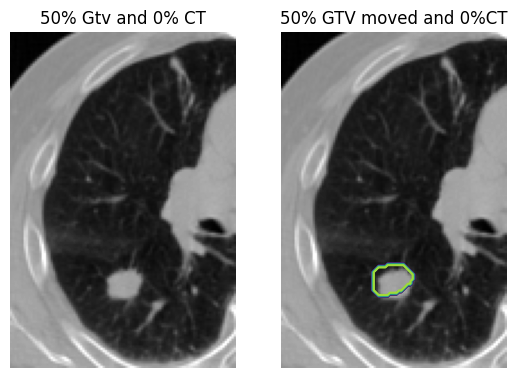

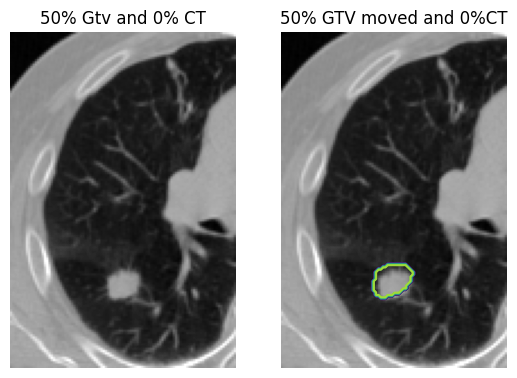

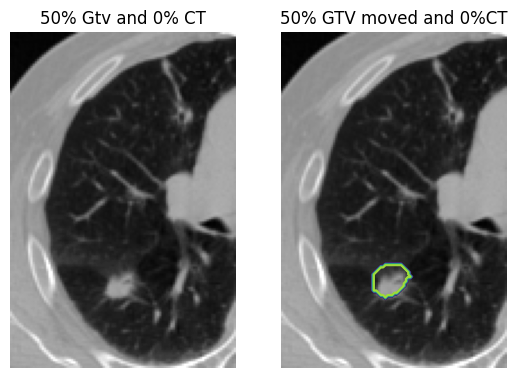

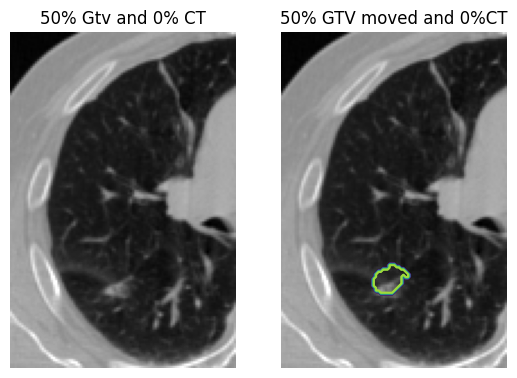

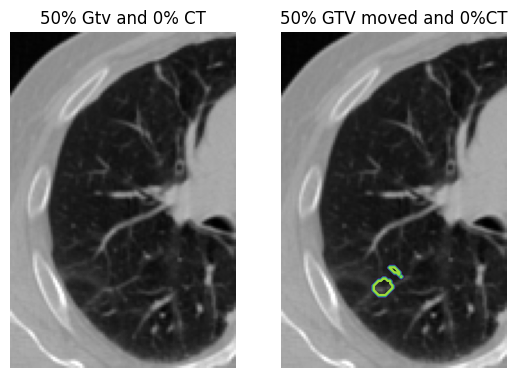

In [47]:
count=0
for i in range(arrayGtv_resampled.shape[-3]):
    if np.sum(arrayGtv_resampled[i,:,:])>0:
        plt.subplot(121),plt.imshow(sitk.GetArrayFromImage(image00_cropClamp[0:100,:,i]),cmap='gray'),plt.axis("off")
        plt.contour(arraygtv_50[i,:,0:100]),plt.title("50% Gtv and 0% CT")
        plt.subplot(122),plt.imshow(sitk.GetArrayFromImage(image00_cropClamp[0:100,:,i]),cmap='gray'),plt.axis("off")
        plt.contour(arrayGtv_resampled[i,:,0:100]),plt.title("50% GTV moved and 0%CT")
        plt.show()
        count+=1
        if count>10:
            break
        